In [3]:
import sys
import torch
import mlflow
import pandas as pd
from datetime import datetime
from darts import TimeSeries
import matplotlib.pyplot as plt
from darts.metrics import mae, mse, mape, rmse
from darts.dataprocessing.transformers.scaler import Scaler
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from darts.models import RNNModel, BlockRNNModel, TCNModel, TransformerModel, TCNModel, NBEATSModel

sys.path.append('../utils/')
from config import config

freq='2H3T14S'
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("OpenMarsCovariates")


<Experiment: artifact_location='mlflow-artifacts:/509720552833119603', creation_time=1712562129260, experiment_id='509720552833119603', last_update_time=1712562129260, lifecycle_stage='active', name='OpenMarsCovariates', tags={}>

In [4]:
def load_dataset(training_file, testing_file):
    dataframes = []
    for data_file in [training_file, testing_file]:
        parser = lambda data_string: datetime.strptime(data_string, '%Y-%m-%d %H:%M:%S')
        dataframe = pd.read_csv(data_file, parse_dates=['Time'],
                                date_parser=parser)
        print(f"Rows in {data_file}: {len(dataframe)}")
        dataframe.drop(['Ls', 'LT', 'CO2ice'], axis=1, inplace=True)
        dataframes.append(dataframe)

    return pd.concat(dataframes, axis=0)


def preprocess(dataframe):
        time = pd.date_range("1998-07-15 21:23:39", periods=len(dataframe), freq=freq)
        dataframe.index = time
        dataframe = dataframe.drop(['Time'], axis=1)
        return dataframe

def create_series(dataframe):
        series = TimeSeries.from_dataframe(dataframe, time_col=None, value_cols=None, fill_missing_dates=True, freq='7394S', fillna_value=None)
        return series

def create_train_val_test_series(series):
        train, temp = series.split_after(0.8)
        val, test = temp.split_after(0.5)
        return train, val, test

In [5]:
dataframe = load_dataset('../data/data_files/insight_openmars_training_time.csv',
                         '../data/data_files/insight_openmars_test_time.csv')
dataframe = preprocess(dataframe)
train, val, test = create_train_val_test_series(create_series(dataframe))
print(len(train), len(val), len(test))

/tmp/ipykernel_3635/787800760.py:5: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  dataframe = pd.read_csv(data_file, parse_dates=['Time'],


Rows in ../data/data_files/insight_openmars_training_time.csv: 72196
Rows in ../data/data_files/insight_openmars_test_time.csv: 16364
70848 8856 8856


/tmp/ipykernel_3635/787800760.py:5: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  dataframe = pd.read_csv(data_file, parse_dates=['Time'],


In [18]:
scaler = Scaler()  # default uses sklearn's MinMaxScaler
train = scaler.fit_transform(train)
val = scaler.transform(val)
test = scaler.transform(test)
from darts.timeseries import concatenate
full_series = concatenate([train, val, test])
lr_scheduler_cls = torch.optim.lr_scheduler.ExponentialLR
my_stopper = EarlyStopping(**config.early_stopping_args)

pl_trainer_kwargs = {"callbacks": [my_stopper]}

common_model_args = {
    "input_chunk_length": 8,  # lookback window
    "output_chunk_length": 7,  # forecast/lookahead window
    "optimizer_kwargs": config.optimizer_kwargs,
    "pl_trainer_kwargs": pl_trainer_kwargs,
    "lr_scheduler_cls": lr_scheduler_cls,
    "lr_scheduler_kwargs": config.lr_scheduler_kwargs,
    "likelihood": None,  # use a likelihood for probabilistic forecasts
    "save_checkpoints": True,  # checkpoint to retrieve the best performing model state,
    "force_reset": True,
    "random_state": 42,
    "n_epochs": 10

}

models = {}

In [8]:
def evaluate_model_forecast(model, test):
    result_accumulator = {}
    print(f'For model {model.model_name}')
    pred_series = model.historical_forecasts(series=test['dust'], 
                                        past_covariates=None,
                                        future_covariates=None,
                                        retrain=False,
                                        verbose=True, 
                                        forecast_horizon=7)
    test_dust = test['dust']
    pred_dust = pred_series
    result_accumulator[model.model_name] = {
        "mae": mae(test_dust, pred_dust),
        "mse": mse(test_dust, pred_dust),
        "mape": mape(test_dust, pred_dust),
        "rmse": rmse(test_dust, pred_dust)
    }
    return result_accumulator, pred_series

In [41]:
def evaluate_model(model, val, test, forecast_horizon,  past_covariates=None ):
    print(f'For model {model.model_name}')
    pred_series = model.historical_forecasts(series=test['dust'], 
    past_covariates=past_covariates,
    future_covariates=None,
    retrain=False,
    verbose=True, 
    forecast_horizon=forecast_horizon,
    overlap_end=True
    )
    metrics_accumulator = {}
    test_dust = scaler.inverse_transform(test)['dust']
    pred_dust = scaler.inverse_transform(pred_series)
    metrics_accumulator[model.model_name] = {
        "mae": mae(test_dust, pred_dust),
        "mse": mse(test_dust, pred_dust),
        "mape": mape(test_dust, pred_dust),
        "rmse": rmse(test_dust, pred_dust)
    }
    return metrics_accumulator, pred_series

In [9]:
def evaluate_model_predict(model, val, test, past_covariates=None ):
    result_accumulator = {}
    print(f'For model {model.model_name}')
    pred_series = model.predict(series = val['dust'], n=len(test), past_covariates=past_covariates)
    # print(pred_series)
    test_dust = test['dust']
    pred_dust = pred_series
    result_accumulator[model.model_name] = {
        "mae_predict": mae(test_dust, pred_dust),
        "mse_predict": mse(test_dust, pred_dust),
        "mape_predict": mape(test_dust, pred_dust),
        "rmse_predict": rmse(test_dust, pred_dust)
    }
    return result_accumulator, pred_series

In [51]:
def train_model(model, train_series, val_series, past_covariates=None, future_covariates=None, val_past_covariates=None, val_future_covariates=None):
    model.fit(
        series=train_series['dust'],
            val_series=val_series['dust'],
            past_covariates=past_covariates,
            val_past_covariates=val_past_covariates,
            future_covariates=future_covariates,
              val_future_covariates=val_future_covariates,

            verbose=True,
)

    models[model.model_name] = model.load_from_checkpoint(model_name=model.model_name, best=True)
    models[model.model_name].save(f'../model_files/{model.model_name}_fixed_input_output_past_covariates.pt')
    return models, model


In [42]:
def logging_forecast(model, past_covariates=None):
    print('model is ' , model)
    with mlflow.start_run(run_name=f'{model.model_name}_fixed_input_output_past_covariates'):

        eval_results, pred_series = evaluate_model(model, val=val, test=test, forecast_horizon = model.output_chunk_length, past_covariates=past_covariates)

        fig2, ax2 = plt.subplots(figsize=(20, 5))
        test['dust'].plot(label = 'Actual', ax = ax2)
        pred_series.plot(label=model.model_name, ax=ax2)


    

In [52]:
def logging_predict(model, past_covariates=None, future_covariates = None):
    print('model is ' , model)
    with mlflow.start_run(run_name=f'{model.model_name}_fixed_input_output_past_covariates'):

        eval_results, pred_series = evaluate_model_predict(model, val=val, test=test, future_covariates=future_covariates)

        fig2, ax2 = plt.subplots(figsize=(20, 5))
        test['dust'].plot(label = 'Actual', ax = ax2)
        pred_series.plot(label=model.model_name, ax=ax2)


    

In [ ]:
# train
model_rnn = BlockRNNModel(model = "LSTM",
                            batch_size = 96,
                            n_rnn_layers = 2,
                            hidden_dim =  30,
                            dropout = 0.25, 
                            **common_model_args, )

models, model  = train_model(model =  model_rnn, train_series= train, val_series= val)

model is  BlockRNNModel(model=LSTM, hidden_dim=30, n_rnn_layers=2, dropout=0.25, batch_size=96, input_chunk_length=8, output_chunk_length=7, optimizer_kwargs={'lr': 0.001}, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x70ca76e0ced0>]}, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ExponentialLR'>, lr_scheduler_kwargs={'gamma': 0.999}, save_checkpoints=True, force_reset=True, random_state=42, n_epochs=10)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


For model 2024-04-08_08_49_26_torch_model_run_3635


Predicting: |          | 0/? [00:00<?, ?it/s]

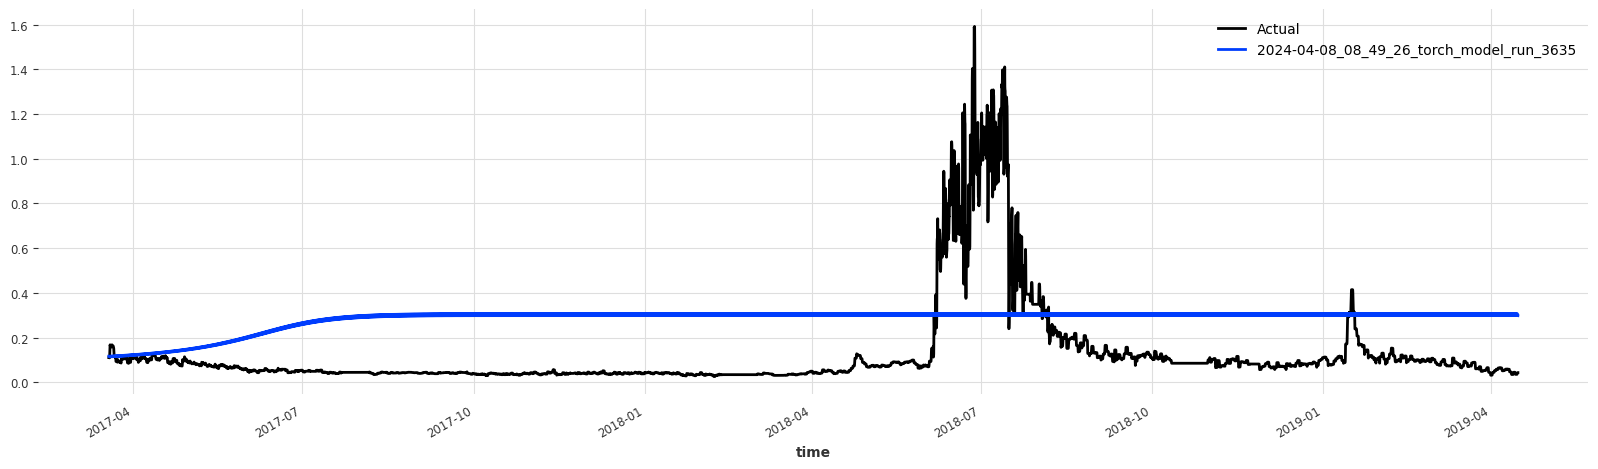

In [14]:
logging_predict(model)

In [53]:
# with past_covariate Tsurf
my_stopper = EarlyStopping(**config.early_stopping_args)

pl_trainer_kwargs = {"callbacks": [my_stopper]}
common_model_args['pl_trainer_kwargs'] = pl_trainer_kwargs
model_rnn = BlockRNNModel(model = "LSTM",
                            batch_size = 96,
                            n_rnn_layers = 2,
                            hidden_dim =  30,
                            dropout = 0.25, 
                            **common_model_args, )

models, model  = train_model(model =  model_rnn, train_series= train, val_series= val, past_covariates = train['Tsurf'], val_past_covariates=val['Tsurf'])


ValueError: Some future_covariates have been provided to a PastCovariates model. These models support only past_covariates.


ValueError: Some future_covariates have been provided to a PastCovariates model. These models support only past_covariates.

In [33]:
# with past_covariate Tsurf and Psurf
my_stopper = EarlyStopping(**config.early_stopping_args)

pl_trainer_kwargs = {"callbacks": [my_stopper]}
common_model_args['pl_trainer_kwargs'] = pl_trainer_kwargs
model_rnn = BlockRNNModel(model = "LSTM",
                            batch_size = 96,
                            n_rnn_layers = 2,
                            hidden_dim =  30,
                            dropout = 0.25, 
                            **common_model_args, )

models, model  = train_model(model =  model_rnn, train_series= train, val_series= val, past_covariates = train['Tsurf'].stack(train['Psurf']), val_past_covariates=val['Tsurf'].stack(val['Psurf']))


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 11.6 K
4 | fc            | Sequential       | 217   
---------------------------------------------------
11.9 K    Trainable params
0         Non-trainable params
11.9 K    Total params
0.047     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


model is  BlockRNNModel(model=LSTM, hidden_dim=30, n_rnn_layers=2, dropout=0.25, batch_size=96, input_chunk_length=8, output_chunk_length=7, optimizer_kwargs={'lr': 0.001}, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x70ca4a3906d0>]}, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ExponentialLR'>, lr_scheduler_kwargs={'gamma': 0.999}, save_checkpoints=True, force_reset=True, random_state=42, n_epochs=10)
For model 2024-04-08_11_55_37_torch_model_run_3635


Predicting: |          | 0/? [00:00<?, ?it/s]

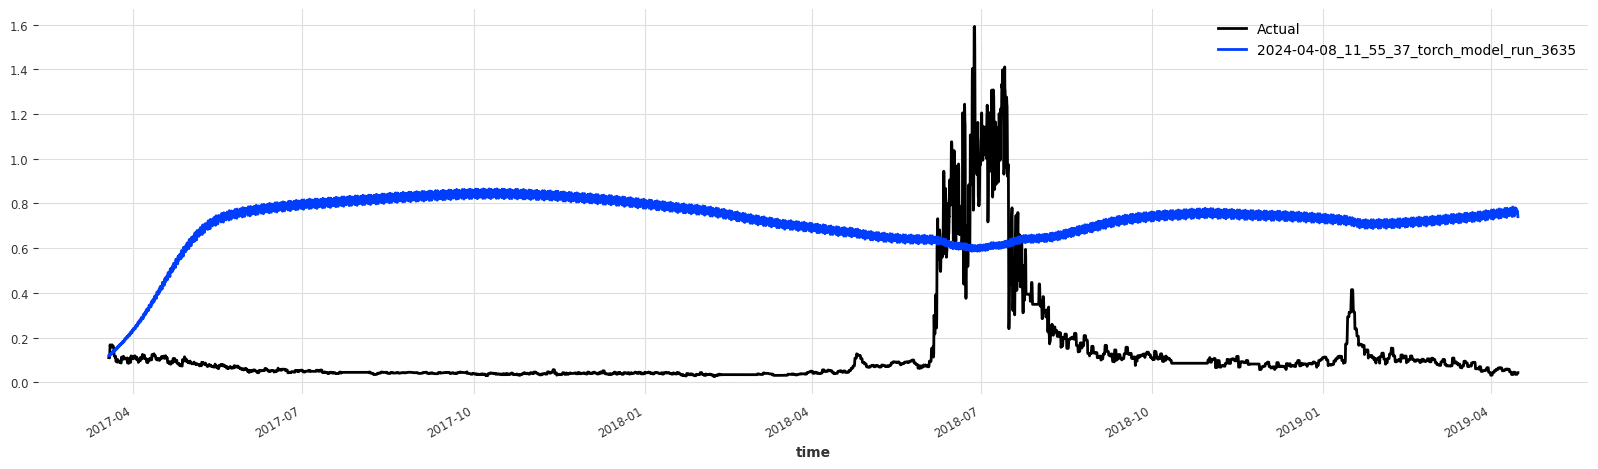

In [45]:
logging_predict(model, past_covariates = full_series['Tsurf'][-len(test)-8:].stack(full_series['Psurf'][-len(test)-8:]))

In [46]:
logging_forecast(model, past_covariates = full_series['Tsurf'][-len(test)-8:].stack(full_series['Psurf'][-len(test)-8:]))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


model is  BlockRNNModel(model=LSTM, hidden_dim=30, n_rnn_layers=2, dropout=0.25, batch_size=96, input_chunk_length=8, output_chunk_length=7, optimizer_kwargs={'lr': 0.001}, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x70ca4a3906d0>]}, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ExponentialLR'>, lr_scheduler_kwargs={'gamma': 0.999}, save_checkpoints=True, force_reset=True, random_state=42, n_epochs=10)
For model 2024-04-08_11_55_37_torch_model_run_3635


Predicting: |          | 0/? [00:00<?, ?it/s]

ValueError: non-broadcastable output operand with shape (8849,1) doesn't match the broadcast shape (8849,8)

In [54]:
my_stopper = EarlyStopping(**config.early_stopping_args)

pl_trainer_kwargs = {"callbacks": [my_stopper]}
common_model_args['pl_trainer_kwargs'] = pl_trainer_kwargs

model_nbeats = NBEATSModel(
    generic_architecture=False,
    num_blocks=3,
    num_layers=4,
    layer_widths=512,
    loss_fn=torch.nn.MSELoss(),
    model_name = 'NBEATSModel',
    **common_model_args,
    batch_size = 32,
    dropout = 0.05

)

models, model  = train_model(model =  model_nbeats, train_series= train, val_series= val, future_covariates = train['Tsurf'], val_future_covariates=val['Tsurf'])
logging_predict(model, future_covariates = full_series['Tsurf'][-len(test)-8:])

ValueError: Some future_covariates have been provided to a PastCovariates model. These models support only past_covariates.


ValueError: Some future_covariates have been provided to a PastCovariates model. These models support only past_covariates.

In [ ]:
my_stopper = EarlyStopping(**config.early_stopping_args)

pl_trainer_kwargs = {"callbacks": [my_stopper]}
common_model_args['pl_trainer_kwargs'] = pl_trainer_kwargs

model_tcn = TCNModel(
    dilation_base=2,
    weight_norm=True,
    kernel_size=2,
    num_filters=6,
    model_name = 'TCNModel', 
    batch_size = 128,
    dropout = 0.05,
    **common_model_args
)



models = train_model(model = model_tcn)

In [ ]:
my_stopper = EarlyStopping(**config.early_stopping_args)

pl_trainer_kwargs = {"callbacks": [my_stopper]}
common_model_args['pl_trainer_kwargs'] = pl_trainer_kwargs

model_transformers = TransformerModel(
    d_model=12,
    nhead=6,
    num_encoder_layers=2,
    num_decoder_layers=4,
    dim_feedforward=64,
    batch_size =32,
    dropout=0.05,
    activation="relu",
    model_name = 'TransformerModel',
    **common_model_args,
)

train_model(model = model_transformers)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Logging model  NBEATSModel(generic_architecture=False, num_blocks=3, layer_widths=512, dropout=0.05, loss_fn=MSELoss(), model_name=NBEATSModel, input_chunk_length=8, output_chunk_length=7, optimizer_kwargs={'lr': 0.001}, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7ff2e02e7350>]}, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ExponentialLR'>, lr_scheduler_kwargs={'gamma': 0.999}, save_checkpoints=True, force_reset=True, random_state=42, n_epochs=10, batch_size=32)
model is  NBEATSModel(generic_architecture=False, num_blocks=3, layer_widths=512, dropout=0.05, loss_fn=MSELoss(), model_name=NBEATSModel, input_chunk_length=8, output_chunk_length=7, optimizer_kwargs={'lr': 0.001}, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7ff2e02e7350>]}, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ExponentialLR'>, lr_scheduler_kwargs={'gamma': 0.999}, save_checkpoints=True, forc

Predicting: |          | 0/? [00:00<?, ?it/s]

{'NBEATSModel': {'mae': 0.12642177681035877, 'mse': 0.03527960425729835, 'mape': 21.67385459868086, 'rmse': 0.18782865664562037}}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Logging model  TCNModel(kernel_size=2, num_filters=6, weight_norm=True, dropout=0.05, model_name=TCNModel, batch_size=128, input_chunk_length=8, output_chunk_length=7, optimizer_kwargs={'lr': 0.001}, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7ff2eee976d0>]}, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ExponentialLR'>, lr_scheduler_kwargs={'gamma': 0.999}, save_checkpoints=True, force_reset=True, random_state=42, n_epochs=10)
model is  TCNModel(kernel_size=2, num_filters=6, weight_norm=True, dropout=0.05, model_name=TCNModel, batch_size=128, input_chunk_length=8, output_chunk_length=7, optimizer_kwargs={'lr': 0.001}, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7ff2eee976d0>]}, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ExponentialLR'>, lr_scheduler_kwargs={'gamma': 0.999}, save_checkpoints=True, force_reset=True, random_state=42, n_epochs=10)
For model TCN

Predicting: |          | 0/? [00:00<?, ?it/s]

{'TCNModel': {'mae': 0.1596122040325786, 'mse': 0.04489916657963581, 'mape': 27.587359307099756, 'rmse': 0.2118942344181073}}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Logging model  RNNModel(model=LSTM, hidden_dim=30, n_rnn_layers=2, dropout=0.25, batch_size=96, input_chunk_length=8, output_chunk_length=7, optimizer_kwargs={'lr': 0.001}, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7ff2e02bd250>]}, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ExponentialLR'>, lr_scheduler_kwargs={'gamma': 0.999}, save_checkpoints=True, force_reset=True, random_state=42, n_epochs=10)
model is  RNNModel(model=LSTM, hidden_dim=30, n_rnn_layers=2, dropout=0.25, batch_size=96, input_chunk_length=8, output_chunk_length=7, optimizer_kwargs={'lr': 0.001}, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7ff2e02bd250>]}, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ExponentialLR'>, lr_scheduler_kwargs={'gamma': 0.999}, save_checkpoints=True, force_reset=True, random_state=42, n_epochs=10)
For model RNNModel


Predicting: |          | 0/? [00:00<?, ?it/s]

{'RNNModel': {'mae': 0.1118656471521338, 'mse': 0.02825213734606108, 'mape': 18.873627382360013, 'rmse': 0.16808372124052073}}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Logging model  TransformerModel(d_model=12, nhead=6, num_encoder_layers=2, num_decoder_layers=4, dim_feedforward=64, dropout=0.05, batch_size=32, model_name=TransformerModel, input_chunk_length=8, output_chunk_length=7, optimizer_kwargs={'lr': 0.001}, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7ff29e2f8ed0>]}, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ExponentialLR'>, lr_scheduler_kwargs={'gamma': 0.999}, save_checkpoints=True, force_reset=True, random_state=42, n_epochs=10)
model is  TransformerModel(d_model=12, nhead=6, num_encoder_layers=2, num_decoder_layers=4, dim_feedforward=64, dropout=0.05, batch_size=32, model_name=TransformerModel, input_chunk_length=8, output_chunk_length=7, optimizer_kwargs={'lr': 0.001}, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7ff29e2f8ed0>]}, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ExponentialLR'>, lr_scheduler_kwarg

Predicting: |          | 0/? [00:00<?, ?it/s]

{'TransformerModel': {'mae': 0.11045529977248436, 'mse': 0.026560700990603613, 'mape': 18.939039381851515, 'rmse': 0.16297454092772776}}


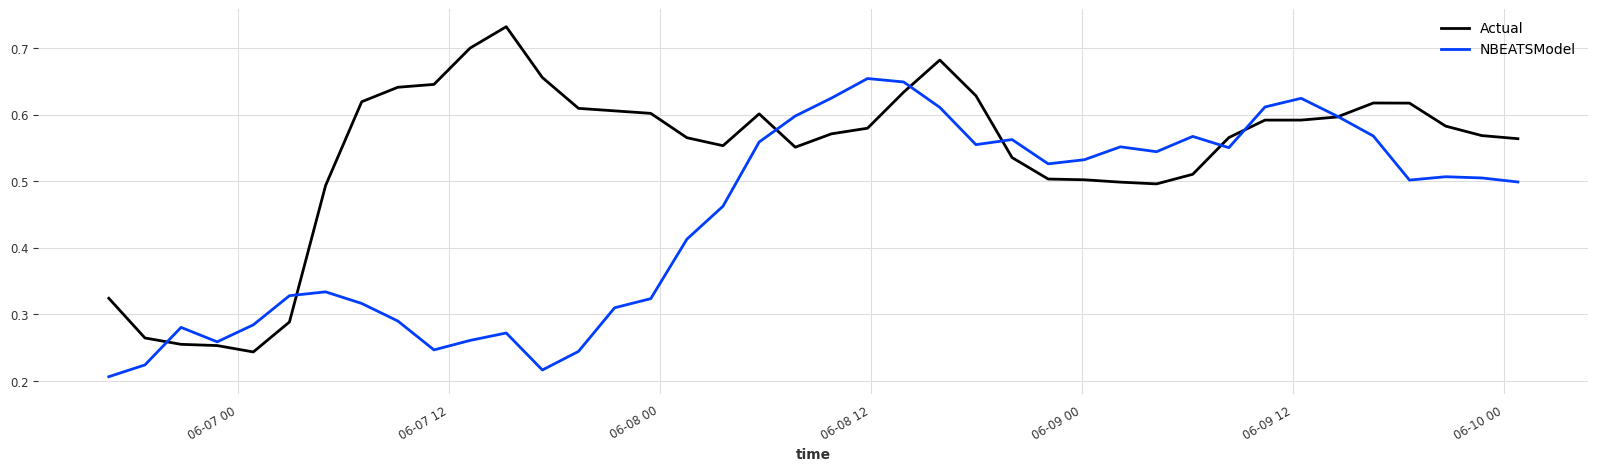

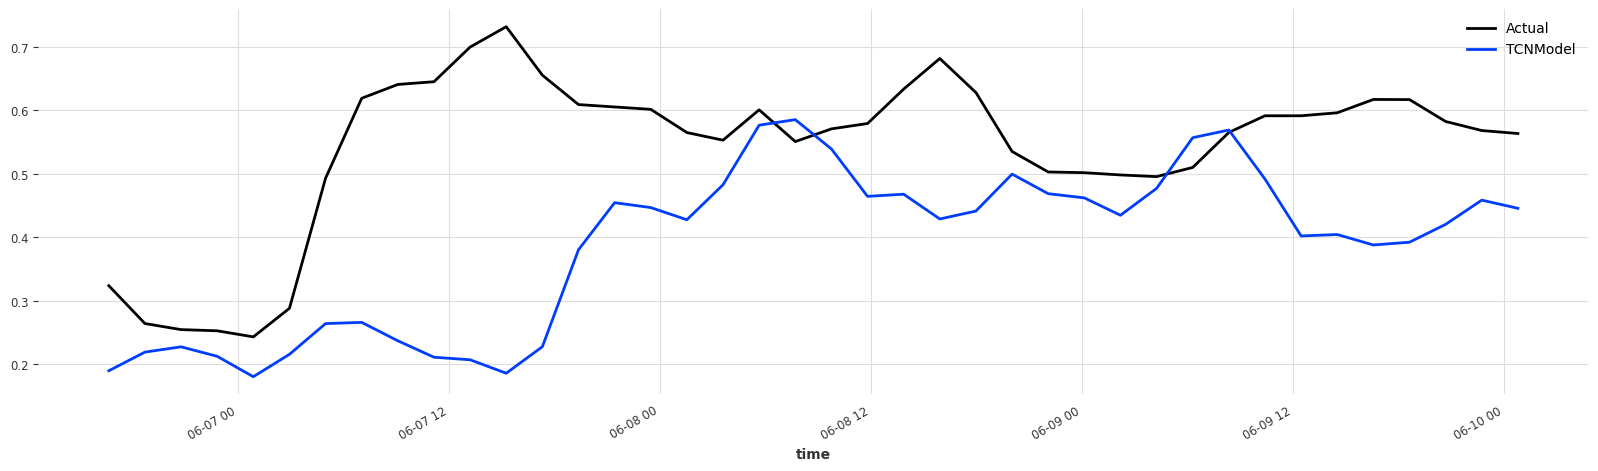

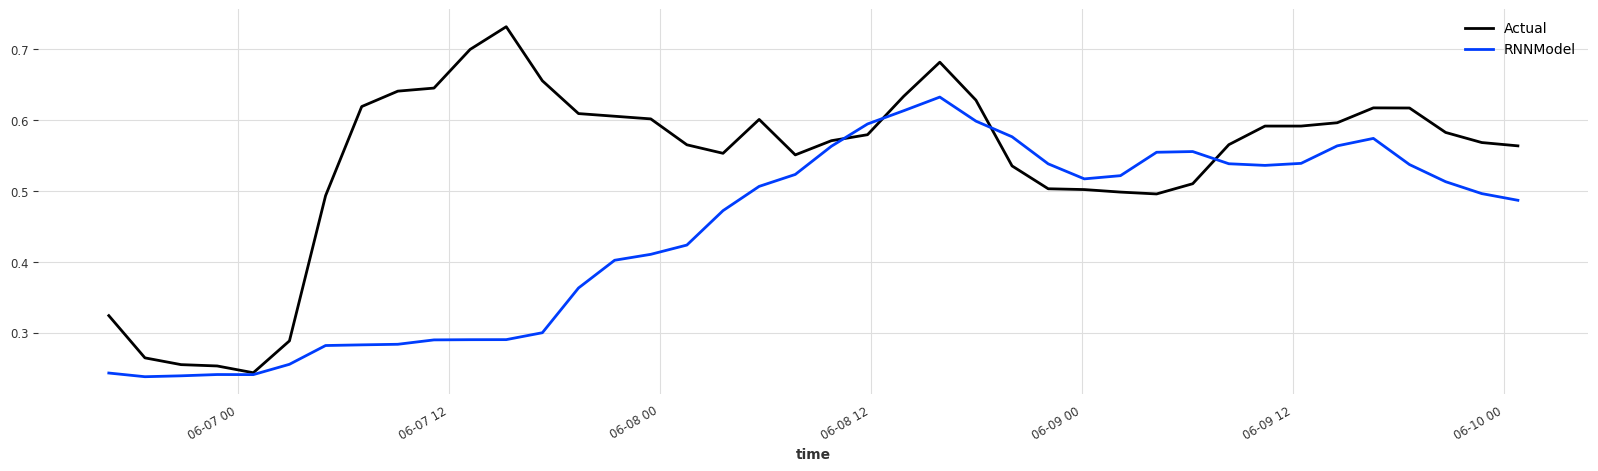

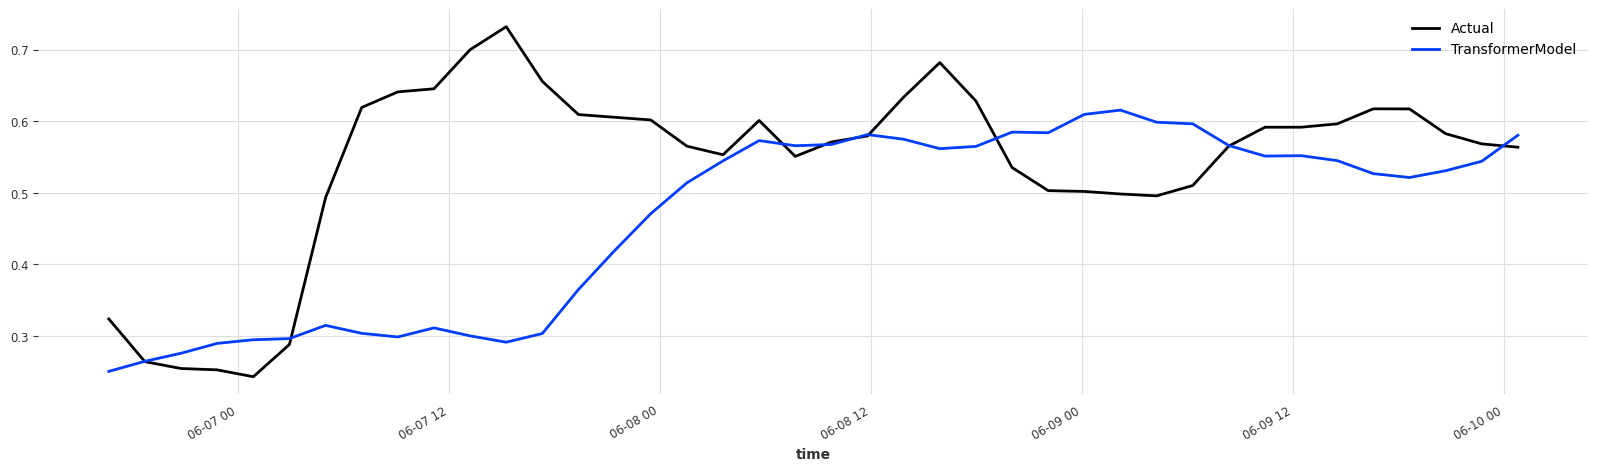

In [59]:
for model_name, model in models.items():
    print('Logging model ', model)
    logging(model)
